# Data Preparation and Processing

In [1]:
import xarray as xr
import numpy as np
from itertools import chain

DATA_DIR = '../../data/datasets'

In [2]:
era5 = xr.open_zarr(
    'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr',
    chunks={'time': 500},
    consolidated=True,
    )
print("Model surface dataset size {} GiB".format(era5.nbytes/(1024**3)))
era5

Model surface dataset size 75.83941642194986 GiB


<xarray.Dataset>
Dimensions:                                           (time: 92040,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -90....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(500, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(500, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(500, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(500, 13, 64, 32), meta=np.ndarray>

### The dataset is still huge, we shrink it

In [3]:
# Select specific data variables
selected_vars = [
    # multi-level variables
    'u_component_of_wind', 'v_component_of_wind',
    'specific_humidity', 'temperature',
    # single-level variables
    '10m_u_component_of_wind', '10m_v_component_of_wind', 
    '10m_wind_speed', 
    '2m_temperature', 
    'mean_sea_level_pressure', 
    'surface_pressure', 'toa_incident_solar_radiation_6hr', 
    'total_cloud_cover', 
    'total_column_water_vapour',
    'total_precipitation_6hr',
    # static variables
    'high_vegetation_cover',
    'low_vegetation_cover',
    'land_sea_mask',
]
era5_selected = era5[selected_vars]

# store selected indices for later
# why? because including multi-level data broadcasts the other features to multi-level
# we will flatten the level, then we need to select which indices to keep
LEVELS = 5
selected_indices = list(chain(range(0, LEVELS*4), range(LEVELS*4, LEVELS*len(selected_vars), LEVELS)))
print(list(selected_indices))

print("Model surface dataset size {} GiB".format(era5_selected.nbytes/(1024**3)))
era5_selected

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
Model surface dataset size 43.53769675642252 GiB


<xarray.Dataset>
Dimensions:                           (time: 92040, level: 13, longitude: 64,
                                       latitude: 32)
Coordinates:
  * latitude                          (latitude) float64 -90.0 -84.19 ... 90.0
  * level                             (level) int64 50 100 150 ... 850 925 1000
  * longitude                         (longitude) float64 0.0 5.625 ... 354.4
  * time                              (time) datetime64[ns] 1959-01-02 ... 20...
Data variables: (12/17)
    u_component_of_wind               (time, level, longitude, latitude) float32 dask.array<chunksize=(500, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind               (time, level, longitude, latitude) float32 dask.array<chunksize=(500, 13, 64, 32), meta=np.ndarray>
    specific_humidity                 (time, level, longitude, latitude) float32 dask.array<chunksize=(500, 13, 64, 32), meta=np.ndarray>
    temperature                       (time, level, longitude, latitude) float32 dask.array<chunksize=(500, 13, 64, 32), meta=np.ndarray>
    10m_u_component_of_wind           (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind           (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    ...                                ...
    total_cloud_cover                 (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    total_column_water_vapour         (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    total_precipitation_6hr           (time, longitude, latitude) float32 dask.array<chunksize=(500, 64, 32), meta=np.ndarray>
    high_vegetation_cover             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    low_vegetation_cover              (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    land_sea_mask                     (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>

In [4]:
# Select a specific range of dimensions
era5_reduced = era5_selected.sel(
    # lat=slice(-90, 90),  # Select latitude range
    # lon=slice(-180, 180),  # Select longitude range
    time=slice('2009-01-01', '2010-01-01'),  # Select time range
).isel(
    level=slice(LEVELS),  # Select pressure level range
)
print("Model surface dataset size {} MiB".format(era5_reduced.nbytes/(1024**2)))
era5_reduced

Model surface dataset size 343.1603775024414 MiB


<xarray.Dataset>
Dimensions:                           (time: 1464, level: 5, longitude: 64,
                                       latitude: 32)
Coordinates:
  * latitude                          (latitude) float64 -90.0 -84.19 ... 90.0
  * level                             (level) int64 50 100 150 200 250
  * longitude                         (longitude) float64 0.0 5.625 ... 354.4
  * time                              (time) datetime64[ns] 2009-01-01 ... 20...
Data variables: (12/17)
    u_component_of_wind               (time, level, longitude, latitude) float32 dask.array<chunksize=(452, 5, 64, 32), meta=np.ndarray>
    v_component_of_wind               (time, level, longitude, latitude) float32 dask.array<chunksize=(452, 5, 64, 32), meta=np.ndarray>
    specific_humidity                 (time, level, longitude, latitude) float32 dask.array<chunksize=(452, 5, 64, 32), meta=np.ndarray>
    temperature                       (time, level, longitude, latitude) float32 dask.array<chunksize=(452, 5, 64, 32), meta=np.ndarray>
    10m_u_component_of_wind           (time, longitude, latitude) float32 dask.array<chunksize=(452, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind           (time, longitude, latitude) float32 dask.array<chunksize=(452, 64, 32), meta=np.ndarray>
    ...                                ...
    total_cloud_cover                 (time, longitude, latitude) float32 dask.array<chunksize=(452, 64, 32), meta=np.ndarray>
    total_column_water_vapour         (time, longitude, latitude) float32 dask.array<chunksize=(452, 64, 32), meta=np.ndarray>
    total_precipitation_6hr           (time, longitude, latitude) float32 dask.array<chunksize=(452, 64, 32), meta=np.ndarray>
    high_vegetation_cover             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    low_vegetation_cover              (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    land_sea_mask                     (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>

## Final Dataset size: 1827 MiB

In [5]:
# has_nans = era5_reduced.isnull().any()
# has_nans.to_array().values

In [6]:
# in case we have nan values, but right now we don't

def fill_na_with_neighbors(da):
    """
    Fill NaN values in the DataArray by averaging their neighbors.
    """
    isnan = np.isnan(da)
    avg_neighbors = np.zeros_like(da)
    count_neighbors = np.zeros_like(da)

    # Shift in all directions and sum up neighbors
    for shift in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        shifted = np.roll(da, shift=shift, axis=(0, 1))
        mask_shifted = np.roll(isnan, shift=shift, axis=(0, 1))
        avg_neighbors += np.where(mask_shifted, 0, shifted)
        count_neighbors += ~mask_shifted

    avg_neighbors = np.where(count_neighbors > 0, avg_neighbors / count_neighbors, np.nan)
    filled = np.where(isnan, avg_neighbors, da)
    return filled

# # Apply the function to all DataArrays in the dataset
# ds_filled = era5_reduced.load().apply(lambda da: xr.apply_ufunc(fill_na_with_neighbors, da))

In [7]:
# Save the reduced dataset to a new file
# era5_reduced.to_netcdf(f'{DATA_DIR}/era5.nc')

# Part 2

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import os
from concurrent.futures import ThreadPoolExecutor

from dask_ml.preprocessing import StandardScaler
from dask_ml.model_selection import train_test_split

In [9]:
# Load the dataset with Dask
# ds = xr.open_dataset(f'{DATA_DIR}/era5.nc', chunks={'time': 10})
ds = era5_reduced

ds_array = ds.to_array()
ds_array

<xarray.DataArray (variable: 17, time: 1464, level: 5, longitude: 64,
                   latitude: 32)>
dask.array<stack, shape=(17, 1464, 5, 64, 32), dtype=float32, chunksize=(1, 500, 5, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * level      (level) int64 50 100 150 200 250
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2009-01-01 ... 2010-01-01T18:00:00
  * variable   (variable) object 'u_component_of_wind' ... 'land_sea_mask'

In [10]:
ds_array.dims, ds_array.coords

(('variable', 'time', 'level', 'longitude', 'latitude'),
 Coordinates:
   * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
   * level      (level) int64 50 100 150 200 250
   * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
   * time       (time) datetime64[ns] 2009-01-01 ... 2010-01-01T18:00:00
   * variable   (variable) object 'u_component_of_wind' ... 'land_sea_mask')

# Flatten Levels

In [11]:
flat_ds = ds_array.stack(feature=['variable', 'level'])
flat_ds = flat_ds.isel(feature=selected_indices)
flat_ds = flat_ds.reset_index('feature')
flat_ds

<xarray.DataArray (time: 1464, longitude: 64, latitude: 32, features: 33)>
dask.array<getitem, shape=(1464, 64, 32, 33), dtype=float32, chunksize=(500, 64, 32, 5), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2009-01-01 ... 2010-01-01T18:00:00
    variable   (features) object 'u_component_of_wind' ... 'land_sea_mask'
    level      (features) int64 50 100 150 200 250 50 100 ... 50 50 50 50 50 50
Dimensions without coordinates: features

In [12]:
# we see a perfect correspondence between the two datasets after all the multi-level data has been exhausted
# ds_array[:, 0, 0, 0, 0].values, flat_ds[0, 0, 0].values

# Create Lag Features

In [13]:
obs_window = 5
pred_window = 2

window = obs_window + pred_window
# Apply the rolling function
rolled_dataset = flat_ds.rolling(time=window, center=False).construct('window')

print(rolled_dataset.shape)

# rolled_dataset.stack(space=['window', 'variable'])
rolled_dataset = rolled_dataset.assign_coords(window=np.arange(1 - obs_window, pred_window + 1, dtype=np.int8))

print(rolled_dataset.shape)

# Drop the NaNs introduced by rolling; dropna too inefficient
# rolled_dataset = rolled_dataset.dropna(dim='time')
rolled_dataset = rolled_dataset.isel(time=slice(window - 1, None))

print(rolled_dataset.shape)

# Manually slice the data to get non-overlapping windows
rolled_dataset = rolled_dataset.isel(time=slice(0, None, window))

print(rolled_dataset.shape)

# Get the data and targets
X = rolled_dataset.isel(window=slice(obs_window))
# .stack(space=['longitude', 'latitude', 'window', 'variable'])
y = rolled_dataset.isel(window=slice(obs_window, None))
# .stack(space=['longitude', 'latitude', 'window', 'variable'])


(1464, 64, 32, 33, 7)
(1464, 64, 32, 33, 7)
(1458, 64, 32, 33, 7)
(209, 64, 32, 33, 7)


In [14]:
X

<xarray.DataArray (time: 209, longitude: 64, latitude: 32, features: 33,
                   window: 5)>
dask.array<getitem, shape=(209, 64, 32, 33, 5), dtype=float32, chunksize=(72, 64, 32, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2009-01-02T12:00:00 ... 2010-01-01T12:00:00
    variable   (features) object 'u_component_of_wind' ... 'land_sea_mask'
    level      (features) int64 50 100 150 200 250 50 100 ... 50 50 50 50 50 50
  * window     (window) int8 -4 -3 -2 -1 0
Dimensions without coordinates: features

# Train-test split

In [15]:
X = X.unstack().stack(space=['longitude', 'latitude', 'window', 'features'])
y = y.unstack().stack(space=['longitude', 'latitude', 'window', 'features'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X.shape, X_train.shape, X_test.shape
X_train

/Users/amarmesic/miniconda3/envs/mlg/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 29 times more chunks
  return self.array[key]


<xarray.DataArray (time: 167, space: 337920)>
dask.array<getitem, shape=(167, 337920), dtype=float32, chunksize=(6, 36960), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2009-09-22 ... 2009-06-30
    variable   (space) object 'u_component_of_wind' ... 'land_sea_mask'
    level      (space) int64 50 100 150 200 250 50 100 ... 50 50 50 50 50 50 50
  * space      (space) object MultiIndex
  * longitude  (space) float64 0.0 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * window     (space) int8 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 ... 0 0 0 0 0 0 0 0 0
  * features   (space) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32

# Scaling

In [16]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
# Since this is regression, we must also scale the y
X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

X_train_scaled

<xarray.DataArray (time: 167, space: 337920)>
dask.array<truediv, shape=(167, 337920), dtype=float32, chunksize=(6, 36960), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2009-09-22 ... 2009-06-30
    variable   (space) object 'u_component_of_wind' ... 'land_sea_mask'
    level      (space) int64 50 100 150 200 250 50 100 ... 50 50 50 50 50 50 50
  * space      (space) object MultiIndex
  * longitude  (space) float64 0.0 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * window     (space) int8 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 ... 0 0 0 0 0 0 0 0 0
  * features   (space) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32

In [17]:
# We may or may not want to flatten the observation window
flatten_window = False

# Concate the window and variable dimensions to get a single vector/dimension of lagged features

X_train_scaled_xr = X_train_scaled.unstack()
y_train_scaled_xr = y_train_scaled.unstack()
X_test_scaled_xr = X_test_scaled.unstack()
y_test_scaled_xr = y_test_scaled.unstack()

if flatten_window:
    # how are variables grouped? Is it [x_(t-1), x_t, x_(t+1)] or not?
    grouping = ['window', 'variable']

    X_train_scaled_xr = X_train_scaled_xr.stack(lag_features=grouping)
    y_train_scaled_xr = y_train_scaled_xr.stack(lag_features=grouping)
    X_test_scaled_xr = X_test_scaled_xr.stack(lag_features=grouping)
    y_test_scaled_xr = y_test_scaled_xr.stack(lag_features=grouping)

y_train_scaled_xr

<xarray.DataArray (time: 167, longitude: 64, latitude: 32, window: 2,
                   features: 33)>
dask.array<reshape, shape=(167, 64, 32, 2, 33), dtype=float32, chunksize=(6, 7, 32, 2, 33), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * window     (window) int8 1 2
  * features   (features) int64 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31 32
  * time       (time) datetime64[ns] 2009-09-22 ... 2009-06-30
    variable   (longitude, latitude, window, features) object 'u_component_of...
    level      (longitude, latitude, window, features) int64 50 100 ... 50 50

In [18]:
ds.longitude.values

array([  0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,  33.75 ,
        39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,  73.125,
        78.75 ,  84.375,  90.   ,  95.625, 101.25 , 106.875, 112.5  ,
       118.125, 123.75 , 129.375, 135.   , 140.625, 146.25 , 151.875,
       157.5  , 163.125, 168.75 , 174.375, 180.   , 185.625, 191.25 ,
       196.875, 202.5  , 208.125, 213.75 , 219.375, 225.   , 230.625,
       236.25 , 241.875, 247.5  , 253.125, 258.75 , 264.375, 270.   ,
       275.625, 281.25 , 286.875, 292.5  , 298.125, 303.75 , 309.375,
       315.   , 320.625, 326.25 , 331.875, 337.5  , 343.125, 348.75 ,
       354.375])

# Make DataSet and DataLoaders


In [19]:
# TEMP FIX: I ACCIDENTALLY SET PREDICTION WINDOW TO 2 INSTEAD OF 1
# y_train_scaled_xr = y_train_scaled_xr.isel(window=0)
# y_test_scaled_xr = y_test_scaled_xr.isel(window=0)

y_train_scaled_xr

<xarray.DataArray (time: 167, longitude: 64, latitude: 32, window: 2,
                   features: 33)>
dask.array<reshape, shape=(167, 64, 32, 2, 33), dtype=float32, chunksize=(6, 7, 32, 2, 33), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * window     (window) int8 1 2
  * features   (features) int64 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31 32
  * time       (time) datetime64[ns] 2009-09-22 ... 2009-06-30
    variable   (longitude, latitude, window, features) object 'u_component_of...
    level      (longitude, latitude, window, features) int64 50 100 ... 50 50

In [25]:
# X_train = torch.tensor(X_train_scaled_xr.values, dtype=torch.float32)
# y_train = torch.tensor(y_train_scaled_xr.values, dtype=torch.float32)
# X_test = torch.tensor(X_test_scaled_xr.values, dtype=torch.float32)
y_test_vals = y_test_scaled_xr.values

In [24]:
y_test = torch.tensor(y_test_vals, dtype=torch.float32)

In [ ]:
# Assuming y_test_scaled_xr is your xarray DataArray

# Step 1: Chunk the DataArray
# Adjust the chunk size as needed for your data
y_test_scaled_xr = y_test_scaled_xr.chunk({'time': 50})

# Step 2: Define a conversion function
def convert_chunk_to_tensor(chunk):
    return torch.from_numpy(chunk.to_numpy())

# Step 3: Parallelize the conversion using ThreadPoolExecutor
chunks = list(y_test_scaled_xr.data)
tensors = []

with ThreadPoolExecutor() as executor:
    future_to_chunk = {executor.submit(convert_chunk_to_tensor, chunk): chunk for chunk in chunks}
    for future in future_to_chunk:
        tensors.append(future.result())

# Step 4: Combine the results into a single PyTorch tensor
y_test = torch.cat(tensors, dim=0)

print(y_test.shape)  # Verify the shape of the resulting tensor


In [ ]:
os.makedirs(f'{DATA_DIR}/64x32_33f_5y_5obs_uns', exist_ok=True)

torch.save(X_train, 'datasets/64x32_33f_5y_5obs_uns/X_train.pt')
torch.save(y_train, 'datasets/64x32_33f_5y_5obs_uns/y_train.pt')
torch.save(X_test, 'datasets/64x32_33f_5y_5obs_uns/X_test.pt')
torch.save(y_test, 'datasets/64x32_33f_5y_5obs_uns/y_test.pt')

RuntimeError: Parent directory datasets/64x32_10f_5y_3obs_uns does not exist.

In [ ]:
from torch.utils.data import Dataset

class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset instances
train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

# Parameters
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_dataset.X.shape

(234, 24576)

## Optional: Make a graph of the grid data

In [ ]:
longitude = ds.longitude.values
latitude = ds.latitude.values

# Initialize a graph
G = nx.Graph()

# Add nodes
for lon in longitude:
    for lat in latitude:
        feature_values = X_test_scaled_xr.isel(time=0).sel(longitude=lon, latitude=lat).values  # Extract features for the first time step
        G.add_node((lon, lat), features=feature_values)

# Add edges (connect each node to its direct neighbors)
for x, lon in enumerate(longitude):
    for y, lat in enumerate(latitude):
        G.add_edge((lon, lat), (longitude[(x + 1) - len(longitude)], lat))  # Connect to the west
        G.add_edge((lon, lat), (lon, latitude[(y + 1)  - len(latitude)]))  # Connect to the north

        # G.add_edge((lon, lat), (longitude[(x + 1) % len(longitude)], lat))  # Connect to the east
        # G.add_edge((lon, lat), (lon, latitude[(x - 1) % len(latitude)]))  # Connect to the south
        

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 2048 nodes and 4096 edges


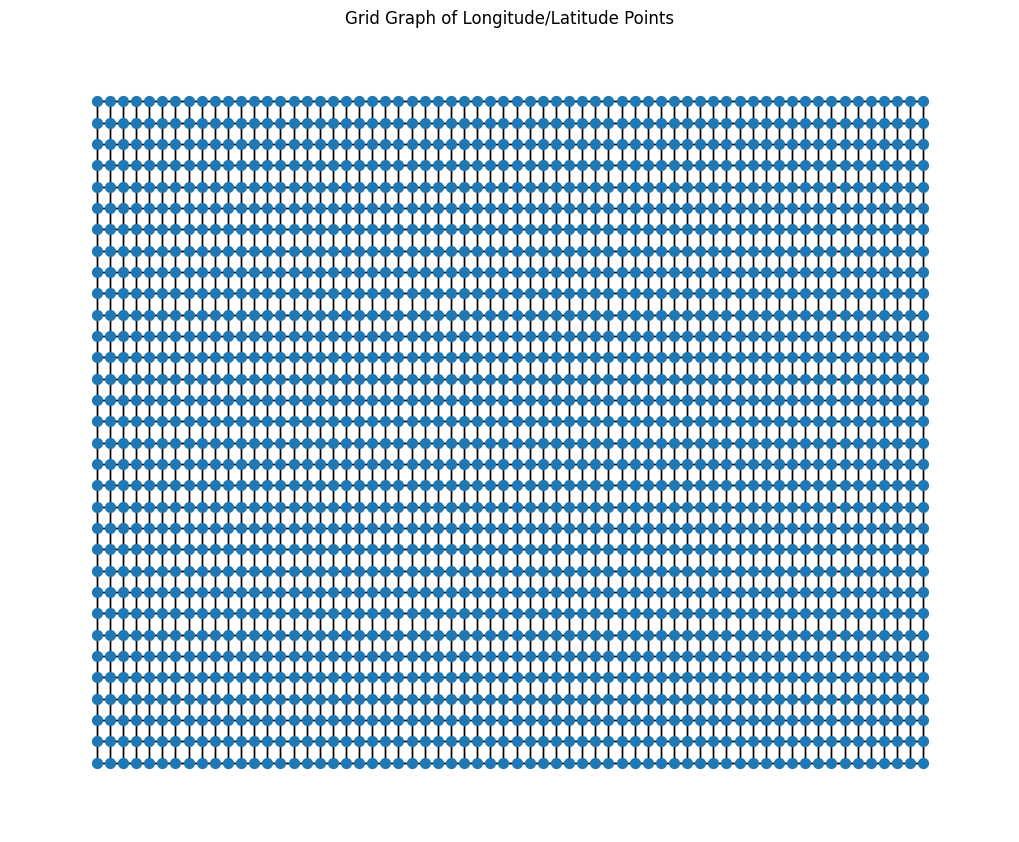

In [ ]:
# Generate positions for the nodes (optional, for better visualization)
pos = {(lon, lat): (lon, lat) for lon in longitude for lat in latitude}

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=False, node_size=50)
plt.title("Grid Graph of Longitude/Latitude Points")
plt.show()